## Model and Alorithms of mTBI Patient Aging Prediction

### Wen Shi, Xi'an Jiaotong University
### Started from 1st March, 2018

In [1]:
# Import 

import xlrd   # read excel
import time   # tick toc
import numpy as np 
import pandas as pd
import seaborn as sns
from skrvm import RVR
from scipy import stats
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVR,SVC
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.preprocessing import normalize
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score  # cross-validation

In [2]:
# Basic function
# import xlsx file
def xlsxfilein(filepath,sheet,data):
    wb=xlrd.open_workbook(file_path)
    ws=wb.sheet_by_name(sheet)
    for r in range(ws.nrows):
        col=[]
        for c in range(ws.ncols):
            col.append(ws.cell(r,c).value)
        data.append(col)
    return data

# easy-plot
def labelxy(xl,yl,labelsize=12):
    plt.xlabel(xl)
    plt.ylabel(yl)

#split-age
def SplitAge(Age,rawdata,N2):    # N2 is the whole feature, Age is a combination of different sections
    N1=rawdata.shape[0]
    k1,k2,k3=0,0,0
    Seg1=np.zeros((N1,N2+1))
    Seg2=np.zeros((N1,N2+1))
    Seg3=np.zeros((N1,N2+1))
    for i in range(N1):
        if rawdata[i,0]<Age[0]:
            Seg1[k1,:]=rawdata[i,:]
            k1=k1+1
    for i in range(N1):
        if (rawdata[i,0]>=Age[1])and(rawdata[i,0]<Age[2]):
            Seg2[k2,:]=rawdata[i,:]
            k2=k2+1
    for i in range(N1):
        if rawdata[i,0]>=Age[3]:
            Seg3[k3,:]=rawdata[i,:]
            k3=k3+1
    Young=Seg1[0:k1,:]
    Middle=Seg2[0:k2,:]
    Elderly=Seg3[0:k3,:]
    return Young,Middle,Elderly

# Append three arrays together
def ArrayAppend(X,Y,Z):
    #### 
    N1,N4=X.shape[0],X.shape[1]
    N2=Y.shape[0]
    N3=Z.shape[0]
    N=N1+N2+N3
    out=np.zeros((N,N4))
    for i in range(N):
        if i<N1:
            out[i]=X[i]
        elif i<(N1+N2):
            out[i]=Y[i-N1]
        else:
            out[i]=Z[i-N1-N2]
    return out
#-------------------------SVR model
def DTISVR3(pca,age,test,test_age,input_kernel,C1):
    svr=SVR(kernel=input_kernel,C=C1)
    N=age.shape[0]
    num_train=test.shape[0]
    svrerror,testerror=np.zeros((N,1)),np.zeros((test.shape[0],1))
    svr_age,pred_age=np.zeros((N,1)),np.zeros((test.shape[0],1))     ####svm_training data age and prediction age 
    t0=time.time()
    svr.fit(pca,age)
    t=time.time()-t0
    print('Traning time:',t,'s')
    s=svr.score(pca,age)
    for i in range(N):
        svr_age[i]=svr.predict(pca[i:i+1,:])
        svrerror[i]=(svr_age[i]-age[i])     # train data - real data
        #print('Real age:',age[i],'SVR age:',svr_age[i],'Difference:',svr_age[i]-age[i])
    for j in range(num_train):
        pred_age[j]=svr.predict(test[j:j+1,:])
        testerror[j]=(pred_age[j]-test_age[j])  
        #print('Test Real age:',test_age[j],'Test SVR age:',pred_age[j],'Difference:',pred_age[j]-test_age[j])
    print('Scores:',s)
#     print('Training error:',svrerror[0])
#     print('Test error:',testerror[0])
#     print('Finished Prediction')
#     print('-----------------------------------------------------------------------')
    return s,svrerror,testerror,svr_age,pred_age
 

#-------------------------RVR model
def DTIRVR3(inp,output,test,test_age,kerl):
    rvr=RVR(kernel=kerl)
    N=output.shape[0]
    rvrerror,testerror=np.zeros((N,1)),np.zeros((test.shape[0],1))
    rvr_age,pred_age=np.zeros((N,1)),np.zeros((test.shape[0],1))
    t0=time.time()
    rvr.fit(inp,output)
    t=time.time()-t0
    print('Training time:',t)
    s=rvr.score(inp,output)
    #scores=cross_val_score(rvr,inp,output,cv=5)
    for i in range(N):
        rvr_age[i]=rvr.predict(inp[i:i+1,:])
        rvrerror[i]=(rvr_age[i]-output[i])
        #print('Real age:',output[i],'RVR age:',rvr_age[i],'Difference:',rvr_age[i]-output[i])
    for j in range(test.shape[0]):
        pred_age[j]=rvr.predict(test[j:j+1,:])
        testerror[j]=(pred_age[j]-test_age[j])
        #print('Test Real age:',test_age[j],'Test RVR age:',pred_age[j],'Difference:',pred_age[j]-test_age[j])
#     print('Training error:',rvrerror[0])
#     print('Test error:',testerror[0])
    print('Score:',s)
    print('RVR Done!')
    return s,rvrerror,testerror,rvr_age,pred_age
#--------------------------------------------------------------
# Age is a array of fraction intervining the saction of the age. 
def SplitMore(Age,rawdata):
    N1=Age.shape[0] ### number is 9
    N2,N3=rawdata.shape[0],rawdata.shape[1]
    k1,k2,k3,k4,k5,k6,k7,k8,k9,k10=0,0,0,0,0,0,0,0,0,0
    Seg1=np.zeros((N2,N3))
    Seg2=np.zeros((N2,N3))
    Seg3=np.zeros((N2,N3))
    Seg4=np.zeros((N2,N3))
    Seg5=np.zeros((N2,N3))
    Seg6=np.zeros((N2,N3))
    Seg7=np.zeros((N2,N3))
    Seg8=np.zeros((N2,N3))
    Seg9=np.zeros((N2,N3))
    Seg10=np.zeros((N2,N3))
    for i in range(N2):
        if rawdata[i,0]<Age[0]:
            Seg1[k1,:]=rawdata[i,:]
            k1=k1+1
        elif rawdata[i,0]<Age[1]:
            Seg2[k2,:]=rawdata[i,:]
            k2=k2+1
        elif rawdata[i,0]<Age[2]:
            Seg3[k3,:]=rawdata[i,:]
            k3=k3+1
        elif rawdata[i,0]<Age[3]:
            Seg4[k4,:]=rawdata[i,:]
            k4=k4+1
        elif rawdata[i,0]<Age[4]:
            Seg5[k5,:]=rawdata[i,:]
            k5=k5+1
        elif rawdata[i,0]<Age[5]:
            Seg6[k6,:]=rawdata[i,:]
            k6=k6+1
        elif rawdata[i,0]<Age[6]:
            Seg7[k7,:]=rawdata[i,:]
            k7=k7+1
        elif rawdata[i,0]<Age[7]:
            Seg8[k8,:]=rawdata[i,:]
            k8=k8+1
        elif rawdata[i,0]<Age[8]:
            Seg9[k9,:]=rawdata[i,:]
            k9=k9+1
        else:
            Seg10[k10,:]=rawdata[i,:]
            k10=k10+1
    Seg1=Seg1[0:k1,:]
    Seg2=Seg2[0:k2,:]
    Seg3=Seg3[0:k3,:]
    Seg4=Seg4[0:k4,:]
    Seg5=Seg5[0:k5,:]
    Seg6=Seg6[0:k6,:]
    Seg7=Seg7[0:k7,:]
    Seg8=Seg8[0:k8,:]
    Seg9=Seg9[0:k9,:]
    Seg10=Seg10[0:k10,:]
    return Seg1,Seg2,Seg3,Seg4,Seg5,Seg6,Seg7,Seg8,Seg9,Seg10

def choose_fiber(Data,coff,xp,threshold,x,p):
    New=Data[:,0]
    n=0
    Q=np.array([])
    P=np.array([])
    if x==1:
        for i in range(50):
            if coff[i]>threshold and xp[i]<p:
                New=np.vstack((New,Data[:,i+1]))
                Q=np.hstack((Q,i+1))
                
    elif x==2:
        for i in range(50):
            if coff[i]<threshold and xp[i]<p:
                New=np.vstack((New,Data[:,i+1]))
                Q=np.hstack((Q,i+1))
                
    else:
        for i in range(50):
            if abs(coff[i])>threshold and xp[i]<p:
                New=np.vstack((New,Data[:,i+1]))
                Q=np.hstack((Q,i+1))          
    return New.T,Q


def choose_test(Data,x):
    Test=Data[:,0]
    for i in range(len(x)):
        Test=np.vstack((Test,Data[:,int(x[i])]))
    return Test.T


In [3]:
def ave(A,B):
    N=A.shape[0]
    C=np.zeros((N,1))
    for i in range(N):
        C[i]=(A[i]+B[i])/2
    return C

In [4]:
def Coffp(X):
    n1,n2=X.shape
    N=n2-1
    P=np.zeros((N,1))
    C=np.zeros((N,1))
    for i in range(N):
        C[i],P[i]=stats.pearsonr(X[:,0].T,X[:,i+1].T)
    return P,C

In [11]:
def Pca_transform(Input,pca, Normalize = True):
    Output = pca.transform(Input)
    if Normalize == True:
        scaler = preprocessing.StandardScaler().fit(Output)
        Output = scaler.transform(Output)
        return Output
    else:
        return Output

In [8]:
file_path = r'C:\Users\Shi Wen\Desktop\DTI_fiber\mean_rawindex.xlsx'
sheet = 'mean1'
data=[]
xlsxfilein(file_path,sheet,data)
data=np.array(data)
print(data.shape,data.dtype) #identification
N1=data.shape[0]
N2=50  ##the number of fiber
rawdata=data[:,0:N2+1]
Q_data=data[:,51:52]
Q_data=np.array(Q_data)
print(Q_data.shape,Q_data.dtype)
print(Q_data[1])
rawdata=rawdata.astype(float)
print('Type of raw data:',rawdata.dtype)
print('Size of raw data:',rawdata.shape)
print('Number of all training data:',rawdata.shape[0])
sele_data=rawdata

(523, 55) <U32
(523, 1) <U32
['0.45123585359999985']
Type of raw data: float64
Size of raw data: (523, 51)
Number of all training data: 523


All Train Shape: (523, 50)
Q_shape: (523, 3) float64  All_a: (523, 1) float64
Y_raw1: (184, 3) M_raw:  (155, 3)  E_raw1: (272, 3)
Young Matrix shape: (184, 51)
Young number: 184   Middle number: 155  Elderly number: 272
Young choose fiber: [ 1.  4. 11. 12. 20. 25. 26. 31. 37. 38. 44.]
Middle choose fiber: [ 3.  4.  5. 10. 12. 15. 16. 17. 19. 20. 22. 23. 24. 25. 26. 27. 29. 30.
 31. 33. 39. 47. 49.]
Elderly choose fiber: [ 1.  3.  4.  5.  6. 17. 18. 23. 24. 25. 27. 28. 29. 30. 31. 32. 33. 34.
 37. 39. 40. 41. 42. 43. 44. 45. 49. 50.]
Test Data Size: (113, 51) Test Data Type: float64
Shape of all healthy test: (113, 50)
(54, 51) (22, 51) (37, 51)
Test Data Size: (104, 51) Test Data Type: float64
Shape of First Patients: (104, 50)
(34, 51) (47, 51) (23, 51)
Test Data Size: (45, 51) Test Data Type: float64
Shape of Second Patients: (45, 50)
(19, 51) (17, 51) (9, 51)
Test Data Size: (36, 51) Test Data Type: float64
Shape of Second Patients: (36, 50)
(14, 51) (15, 51) (7, 51)
Test Data Size:

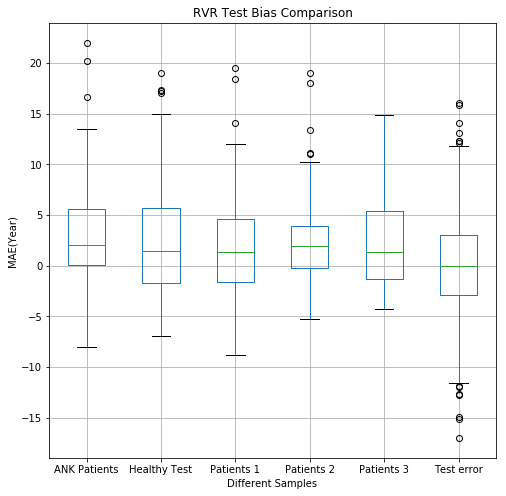

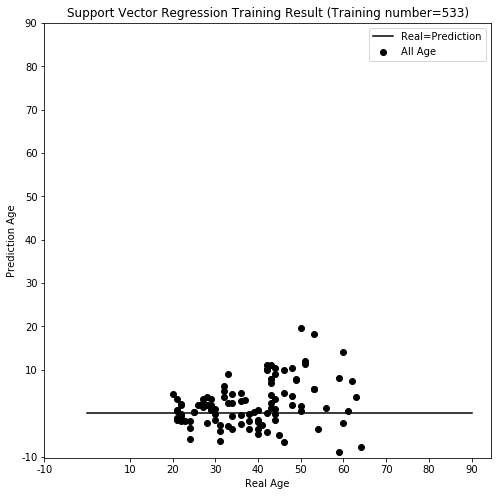

In [13]:
All_age=sele_data[:,0]  #32-26-48-42-0.1
Year_fic11=29.5 #29.5 
Year_fic21=25.1 #26
Year_fic31=48
Year_fic41=42
All_data=sele_data[:,1:51]                            # training data all fiber
print('All Train Shape:',All_data.shape)
u=0
rvrmae_young=np.zeros((11,1))
#training data all age
#Hyperparams
for x0 in range(1):
    Year_fic11=32+x0*2
    for y0 in range(1):
        Year_fic21=26+y0
        #if (Year_fic21+2)<Year_fic11:
        for z0 in range(1):
            Year_fic31=48+z0
            for a0 in range(1):
                Year_fic41=42+a0
                if (Year_fic41+6)>Year_fic31:
                    break
                else:
                            # training data all fiber
                    Age=np.array([Year_fic11,Year_fic21,Year_fic31,Year_fic41])                        #<25/25-55/>=55   1-30/20/55/40
                    Age1=np.array([Year_fic11,Year_fic11,Year_fic31,Year_fic31]) 
                    Age2=np.array([Year_fic21,Year_fic21,Year_fic41,Year_fic41]) 
                    YoungAll,MiddleAll,ElderlyAll=SplitAge(Age,rawdata,50) # fiber_number
                    All_a=np.zeros((523,1))
                    Q=np.zeros((523,1))
                    for i in range(523):
                        All_a[i]=sele_data[i,0]
                    
                        Q[i]=float(Q_data[i])
                    Q=np.hstack((np.hstack((All_a,Q)),Q))
                    #print(Q[0,:])
                    print('Q_shape:',Q.shape,Q.dtype,' All_a:',All_a.shape,All_a.dtype)
                    Y_raw,M_raw,E_raw=SplitAge(Age,Q,2)
                    print('Y_raw1:',Y_raw.shape,'M_raw: ',M_raw.shape,' E_raw1:',E_raw.shape)
                    #YY,MM,EE=SplitAge(Age,Q_data,1)
                    
                    #Nu=100
                    #Young,Middle,Elderly=YoungAll[0:Nu,:],MiddleAll[0:Nu,:],ElderlyAll[0:Nu,:]
                    #All_data=ArrayAppend(Young,Middle,Elderly)[:,1:51]
                    #All_age=ArrayAppend(Young,Middle,Elderly)[:,0]
                    Young=YoungAll[:,:] 
                    Middle=MiddleAll[:,:] 
                    Elderly=ElderlyAll[:,:] 
                    Young_num=Young.shape[0]
                    Middle_num=Middle.shape[0]
                    Elderly_num=Elderly.shape[0]  
                    print('Young Matrix shape:',Young.shape)
                    Se=All_data.shape[1]
                    print('Young number:',Young_num,'  Middle number:',Middle_num,' Elderly number:',Elderly_num)
                    # age
                    #############################
                    y_cof,m_cof,e_cof=np.corrcoef(Young,rowvar=0),np.corrcoef(Middle,rowvar=0),np.corrcoef(Elderly,rowvar=0)
                    y_coff,m_coff,e_coff=y_cof[0,1:51],m_cof[0,1:51],e_cof[0,1:51]
                    Y_P,Y_C=Coffp(Young)
                    M_P,M_C=Coffp(Middle)
                    E_P,E_C=Coffp(Elderly)
#                     print('Y_P:',Y_P,'Y_C',Y_C)
#                     print('M_P:',M_P,'M_P',M_C)
#                     print('E_P:',E_P,'E_C',E_C)
#                     print('Young coff size:',y_coff.shape,'Max:',np.max(y_coff),'Min:',np.min(y_coff))
#                     print('Middle coff size:',m_coff.shape,'Max:',np.max(m_coff),'Min:',np.min(m_coff))
#                     print('Elderly coff size:',e_coff.shape,'Max:',np.max(e_coff),'Min:',np.min(e_coff))
                    # p-value setting
                    p1,p2,p3=0.05,0.05,0.05
                    Yo,Yo_fiber=choose_fiber(Young,y_coff,Y_P,0.1,3,p1)
                    Mi,Mi_fiber=choose_fiber(Middle,m_coff,M_P,0.2,3,p2)
                    El,El_fiber=choose_fiber(Elderly,e_coff,E_P,0.3,3,p3)
                    print('Young choose fiber:',Yo_fiber)
                    print('Middle choose fiber:',Mi_fiber)
                    print('Elderly choose fiber:',El_fiber)
                    Young_age=Yo[:,0]
                    Middle_age=Mi[:,0]
                    Elderly_age=El[:,0]
                    # fiber preprocessing z-score
                    Y_fiber=Yo[:,1:len(Yo_fiber)+1]
                    M_fiber=Mi[:,1:len(Mi_fiber)+1]
                    E_fiber=El[:,1:len(El_fiber)+1]
                    ##----------------------------------Load Test Healthy Data
                    file_path=r'C:\Users\Shi Wen\Desktop\DTI_fiber\test_data_all.xlsx'
                    #sheet='median_com'
                    sheet='mean_com'
                    testdata=[]
                    # seperating params
                    
                    a=0.5
                    b=0.5
                    Year_fic12=a * Year_fic11 + (1-a) * Year_fic21
                    Year_fic22=Year_fic12
                    Year_fic32=b * Year_fic31 + (1-b) * Year_fic41
                    Year_fic42=Year_fic32
                    xlsxfilein(file_path,sheet,testdata)
                    testdata=np.array(testdata)
                    print('Test Data Size:',testdata.shape,'Test Data Type:',testdata.dtype)                              #  identification
                    All_test_age=testdata[:,0]                                        #  test age
                    All_test=testdata[:,1:51]                                         #  test data
                    print('Shape of all healthy test:',All_test.shape)
                    

                    Age=np.array([Year_fic12,Year_fic22,Year_fic32,Year_fic42])
                    Y_rawtest1,M_rawtest1,E_rawtest1=SplitAge(Age1,testdata,50)
                    Y_rawtest2,M_rawtest2,E_rawtest2=SplitAge(Age2,testdata,50)                 
                    print(Y_rawtest1.shape,M_rawtest1.shape,E_rawtest1.shape)
                    Y_test_age1,Y_test1=Y_rawtest1[:,0],choose_test(Y_rawtest1,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    M_test_age1,M_test1=M_rawtest1[:,0],choose_test(M_rawtest1,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    E_test_age1,E_test1=E_rawtest1[:,0],choose_test(E_rawtest1,El_fiber)[:,1:len(El_fiber)+1]
                    Y_test_age2,Y_test2=Y_rawtest2[:,0],choose_test(Y_rawtest2,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    M_test_age2,M_test2=M_rawtest2[:,0],choose_test(M_rawtest2,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    E_test_age2,E_test2=E_rawtest2[:,0],choose_test(E_rawtest2,El_fiber)[:,1:len(El_fiber)+1]
                    
                    # Load Patient Data
                    print('===================================================================')
                    file_path=r'C:\Users\Shi Wen\Desktop\DTI_fiber\test_data_all.xlsx'
                    #sheet='median_pat'
                    sheet='mean_pat'
                    P_data=[]
                    xlsxfilein(file_path,sheet,P_data)
                    P_data=np.array(P_data)
                    print('Test Data Size:',P_data.shape,'Test Data Type:',P_data.dtype) 
                    P_All_test_age=P_data[:,0]                                             # patient test age
                    P_All_test=P_data[:,1:51]                                              #  patient test data
                    print('Shape of First Patients:',P_All_test.shape)
                    ###################################################################
                    PY_rawtest1,PM_rawtest1,PE_rawtest1=SplitAge(Age1,P_data,50)
                    PY_rawtest2,PM_rawtest2,PE_rawtest2=SplitAge(Age2,P_data,50)
                    print(PY_rawtest1.shape,PM_rawtest1.shape,PE_rawtest1.shape)
                    PY_age1,PY_test1=PY_rawtest1[:,0],choose_test(PY_rawtest1,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    PM_age1,PM_test1=PM_rawtest1[:,0],choose_test(PM_rawtest1,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    PE_age1,PE_test1=PE_rawtest1[:,0],choose_test(PE_rawtest1,El_fiber)[:,1:len(El_fiber)+1]
                    PY_age2,PY_test2=PY_rawtest2[:,0],choose_test(PY_rawtest2,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    PM_age2,PM_test2=PM_rawtest2[:,0],choose_test(PM_rawtest2,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    PE_age2,PE_test2=PE_rawtest2[:,0],choose_test(PE_rawtest2,El_fiber)[:,1:len(El_fiber)+1]
                    
                    #################################################################### FA t2
                    file_path = r'C:\Users\Shi Wen\Desktop\DTI_fiber\FA_t2.xlsx'
                    P2_data=[]
                    xlsxfilein(file_path,'Sheet1',P2_data)
                    P2_data=np.array(P2_data)
                    print('Test Data Size:',P2_data.shape,'Test Data Type:',P2_data.dtype) 
                    P2_All_test_age=P2_data[:,0]                                             # patient test age
                    P2_All_test=P2_data[:,1:51]                                              #  patient test data
                    print('Shape of Second Patients:',P2_All_test.shape)
                    PY2_rawtest1,PM2_rawtest1,PE2_rawtest1=SplitAge(Age1,P2_data,50)
                    PY2_rawtest2,PM2_rawtest2,PE2_rawtest2=SplitAge(Age2,P2_data,50)
                    print(PY2_rawtest1.shape,PM2_rawtest1.shape,PE2_rawtest1.shape)
                    PY2_age1,PY2_test1=PY2_rawtest1[:,0],choose_test(PY2_rawtest1,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    PM2_age1,PM2_test1=PM2_rawtest1[:,0],choose_test(PM2_rawtest1,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    PE2_age1,PE2_test1=PE2_rawtest1[:,0],choose_test(PE2_rawtest1,El_fiber)[:,1:len(El_fiber)+1]
                    PY2_age2,PY2_test2=PY2_rawtest2[:,0],choose_test(PY2_rawtest2,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    PM2_age2,PM2_test2=PM2_rawtest2[:,0],choose_test(PM2_rawtest2,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    PE2_age2,PE2_test2=PE2_rawtest2[:,0],choose_test(PE2_rawtest2,El_fiber)[:,1:len(El_fiber)+1]
                    
                    #####################################################################
                    file_path=r'C:\Users\Shi Wen\Desktop\DTI_fiber\FA_t3.xlsx'
                    P3_data=[]
                    xlsxfilein(file_path,'Sheet1',P3_data)
                    P3_data=np.array(P3_data)
                    print('Test Data Size:',P3_data.shape,'Test Data Type:',P3_data.dtype) 
                    P3_All_test_age=P3_data[:,0]                                             # patient test age
                    P3_All_test=P3_data[:,1:51]                                              #  patient test data
                    print('Shape of Second Patients:',P3_All_test.shape)
                    PY3_rawtest1,PM3_rawtest1,PE3_rawtest1=SplitAge(Age1,P3_data,50)
                    PY3_rawtest2,PM3_rawtest2,PE3_rawtest2=SplitAge(Age2,P3_data,50)
                    print(PY3_rawtest1.shape,PM3_rawtest1.shape,PE3_rawtest1.shape)
                    PY3_age1,PY3_test1=PY3_rawtest1[:,0],choose_test(PY3_rawtest1,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    PM3_age1,PM3_test1=PM3_rawtest1[:,0],choose_test(PM3_rawtest1,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    PE3_age1,PE3_test1=PE3_rawtest1[:,0],choose_test(PE3_rawtest1,El_fiber)[:,1:len(El_fiber)+1]
                    PY3_age2,PY3_test2=PY3_rawtest2[:,0],choose_test(PY3_rawtest2,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    PM3_age2,PM3_test2=PM3_rawtest2[:,0],choose_test(PM3_rawtest2,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    PE3_age2,PE3_test2=PE3_rawtest2[:,0],choose_test(PE3_rawtest2,El_fiber)[:,1:len(El_fiber)+1]
                    #####################################################################
    #                 file_path=r'C:\Users\Shi Wen\Desktop\DTI_fiber\mean_index.xlsx'
    #                 sheet='ank'
    #                 adata=[]
    #                 xlsxfilein(file_path,sheet,adata)
    #                 adata=np.array(adata)
    #                 print(adata.shape,adata.dtype) #identification
    #                 N1=adata.shape[0]
    #                 awdata=adata[:,0:51]
    #                 awdata=awdata.astype(float)
    #                 print('Test Data Size:',awdata.shape,'Test Data Type:',awdata.dtype) 
    #                 a_All_test_age=awdata[:,0]                                             # patient test age
    #                 a_All_test=awdata[:,1:51]                                              #  patient test data
    #                 print('Shape of Second Patients:',a_All_test.shape)
    #                 AY_rawtest,AM_rawtest,AE_rawtest=SplitAge(Age,awdata,50)
    #                 print(AY_rawtest.shape,AM_rawtest.shape,AE_rawtest.shape)
    #                 AY_age,AY_test=AY_rawtest[:,0],choose_test(AY_rawtest,Yo_fiber)[:,1:len(Yo_fiber)+1]
    #                 AM_age,AM_test=AM_rawtest[:,0],choose_test(AM_rawtest,Mi_fiber)[:,1:len(Mi_fiber)+1]
    #                 AE_age,AE_test=AE_rawtest[:,0],choose_test(AE_rawtest,El_fiber)[:,1:len(El_fiber)+1]
                    ####################################################################
                    file_path=r'C:\Users\Shi Wen\Desktop\DTI_fiber\FA_ank.xlsx'
                    P4_data=[]
                    xlsxfilein(file_path,'Sheet1',P4_data)
                    P4_data=np.array(P4_data)
                    print('Test Data Size:',P4_data.shape,'Test Data Type:',P4_data.dtype) 
                    P4_All_test_age=P4_data[:,0]                                             # patient test age
                    P4_All_test=P4_data[:,1:51]                                              #  patient test data
                    print('Shape of Second Patients:',P4_All_test.shape)
                    PY4_rawtest1,PM4_rawtest1,PE4_rawtest1=SplitAge(Age1,P4_data,50)
                    PY4_rawtest2,PM4_rawtest2,PE4_rawtest2=SplitAge(Age2,P4_data,50)
                    print(PY4_rawtest1.shape,PM4_rawtest1.shape,PE4_rawtest1.shape)
                    PY4_age1,PY4_test1=PY4_rawtest1[:,0],choose_test(PY4_rawtest1,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    PM4_age1,PM4_test1=PM4_rawtest1[:,0],choose_test(PM4_rawtest1,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    PE4_age1,PE4_test1=PE4_rawtest1[:,0],choose_test(PE4_rawtest1,El_fiber)[:,1:len(El_fiber)+1]
                    PY4_age2,PY4_test2=PY4_rawtest2[:,0],choose_test(PY4_rawtest2,Yo_fiber)[:,1:len(Yo_fiber)+1]
                    PM4_age2,PM4_test2=PM4_rawtest2[:,0],choose_test(PM4_rawtest2,Mi_fiber)[:,1:len(Mi_fiber)+1]
                    PE4_age2,PE4_test2=PE4_rawtest2[:,0],choose_test(PE4_rawtest2,El_fiber)[:,1:len(El_fiber)+1]
                    print('Shape of Patients 1:',P_All_test.shape)
                    print('Shape of Patients 2:',P2_All_test.shape)
                    print('Shape of Patients 2:',P3_All_test.shape)
                    print('Shape of Patients 3:',P4_All_test.shape)
                    print('Young Train Samples Size:',Y_fiber.shape)
                    print('Middle Train Samples Size:',M_fiber.shape)
                    print('Elderly Train Samples Size:',E_fiber.shape)
                    print('Young Healthy Test shape:',Y_test1.shape)
                    print('Middle Healthy Test shape:',M_test1.shape)
                    print('Elderly Healthy Test shape:',E_test1.shape)
                    print('Young Patient:',PY_test1.shape,'Middle patients:',PM_test1.shape,'Elderly patients:',PE_test1.shape)
                    #################################################################################
                    for a in range(1):
                        for b in range(1):
                            for c in range(1):
                                n1,n2,n3=8,8,8
                                
                                # Young
                                PCA_ratio = n1 #主成分所占权重
                                pca = PCA(n_components = PCA_ratio)
                                pca.fit(Y_fiber)
                                print('Young:',pca.explained_variance_ratio_,'Var:',pca.explained_variance_) 
                                # Normalization
                                scaler = preprocessing.StandardScaler().fit(Y_fiber)
                                Y_pca = scaler.transform(Y_fiber)
                                Y_test_pca1 = scaler.transform(Y_test1)
                                Y_test_pca2 = scaler.transform(Y_test2)
                                PY_pca1 = scaler.transform(PY_test1)
                                PY_pca2 = scaler.transform(PY_test2)
                                PY2_pca1 = scaler.transform(PY2_test1)
                                PY2_pca2 = scaler.transform(PY2_test2)
                                PY3_pca1 = scaler.transform(PY3_test1)
                                PY3_pca2 = scaler.transform(PY3_test2)
                                PY4_pca1 = scaler.transform(PY4_test1)
                                PY4_pca2 = scaler.transform(PY4_test2)
                                
                                # PCA transformation
                                
                                Y_pca = Pca_transform(Y_pca,pca)
                                Y_test_pca1 = Pca_transform(Y_test_pca1,pca)
                                Y_test_pca2 = Pca_transform(Y_test_pca2,pca)
                                PY_pca1 = Pca_transform(PY_pca1,pca)
                                PY_pca2 = Pca_transform(PY_pca2,pca)
                                PY2_pca1 = Pca_transform(PY2_pca1,pca)
                                PY2_pca2 = Pca_transform(PY2_pca2,pca)
                                PY3_pca1 = Pca_transform(PY3_pca1,pca)
                                PY3_pca2 = Pca_transform(PY3_pca2,pca)
                                PY4_pca1 = Pca_transform(PY4_pca1,pca)
                                PY4_pca2 = Pca_transform(PY4_pca2,pca)
                                
                                print('Young fiber PCA shape:',Y_pca.shape,'Young Test Sample Shape:',
                                      Y_test1.shape,'to',Y_test_pca1.shape,'PYpca:',PY_pca1.shape)
                                
                                # Middle Age 
                                # Training set
                                PCA_ratio = n2 # pca components
                                pca = PCA(n_components = PCA_ratio)
                                pca.fit(M_fiber)
                                print('Middle:',pca.explained_variance_ratio_,'Var:',pca.explained_variance_) 
                                # Normalization
                                scaler = preprocessing.StandardScaler().fit(M_fiber)
                                M_pca = scaler.transform(M_fiber)
                                M_test_pca1 = scaler.transform(M_test1)
                                M_test_pca2 = scaler.transform(M_test2)
                                PM_pca1 = scaler.transform(PM_test1)
                                PM_pca2 = scaler.transform(PM_test2)
                                PM2_pca1 = scaler.transform(PM2_test1)
                                PM2_pca2 = scaler.transform(PM2_test2)
                                PM3_pca1 = scaler.transform(PM3_test1)
                                PM3_pca2 = scaler.transform(PM3_test2)
                                PM4_pca1 = scaler.transform(PM4_test1)
                                PM4_pca2 = scaler.transform(PM4_test2)
                                
                                # PCA transformation
                                
                                M_pca = Pca_transform(M_pca,pca)
                                M_test_pca1 = Pca_transform(M_test_pca1,pca)
                                M_test_pca2 = Pca_transform(M_test_pca2,pca)
                                PM_pca1 = Pca_transform(PM_pca1,pca)
                                PM_pca2 = Pca_transform(PM_pca2,pca)
                                PM2_pca1 = Pca_transform(PM2_pca1,pca)
                                PM2_pca2 = Pca_transform(PM2_pca2,pca)
                                PM3_pca1 = Pca_transform(PM3_pca1,pca)
                                PM3_pca2 = Pca_transform(PM3_pca2,pca)
                                PM4_pca1 = Pca_transform(PM4_pca1,pca)
                                PM4_pca2 = Pca_transform(PM4_pca2,pca)

                                # Elderly 
                                PCA_ratio=n3 #主成分所占权重
                                pca = PCA(n_components = PCA_ratio)
                                pca.fit(E_fiber)
                                print('Elderly:',pca.explained_variance_ratio_,'Var:',pca.explained_variance_) 
                                
                                # Normalization
                                scaler = preprocessing.StandardScaler().fit(E_fiber)
                                E_pca = scaler.transform(E_fiber)
                                E_test_pca1 = scaler.transform(E_test1)
                                E_test_pca2 = scaler.transform(E_test2)
                                PE_pca1 = scaler.transform(PE_test1)
                                PE_pca2 = scaler.transform(PE_test2)
                                PE2_pca1 = scaler.transform(PE2_test1)
                                PE2_pca2 = scaler.transform(PE2_test2)
                                PE3_pca1 = scaler.transform(PE3_test1)
                                PE3_pca2 = scaler.transform(PE3_test2)
                                PE4_pca1 = scaler.transform(PE4_test1)
                                PE4_pca2 = scaler.transform(PE4_test2)
                                
                                # PCA transformation
                                
                                E_pca = Pca_transform(E_pca,pca)
                                E_test_pca1 = Pca_transform(E_test_pca1,pca)
                                E_test_pca2 = Pca_transform(E_test_pca2,pca)
                                PE_pca1 = Pca_transform(PE_pca1,pca)
                                PE_pca2 = Pca_transform(PE_pca2,pca)
                                PE2_pca1 = Pca_transform(PE2_pca1,pca)
                                PE2_pca2 = Pca_transform(PE2_pca2,pca)
                                PE3_pca1 = Pca_transform(PE3_pca1,pca)
                                PE3_pca2 = Pca_transform(PE3_pca2,pca)
                                PE4_pca1 = Pca_transform(PE4_pca1,pca)
                                PE4_pca2 = Pca_transform(PE4_pca2,pca)
                                
                                # PCA_ratio=n4 #主成分所占权重
    #                             pca = PCA(n_components=PCA_ratio)
    #                             #----------------------All
    #                             pca.fit(All_data)
    #                             All_pca=pca.transform(All_data)
    #                             pca.fit(All_test)
    #                             All_test_pca=pca.transform(All_test)
    #                             pca.fit(P_All_test)
    #                             P_All_pca=pca.transform(P_All_test)

                                #---------------------display calculation
                #                 print(Y_pca.shape)
                #                 print(M_pca.shape)
                #                 print(E_pca.shape)
                #                 # print(All_pca.shape)
                #                 print('Young Patient Pca:',PY_pca.shape[0])
                #                 print('Middle Patient Pca:',PM_pca.shape[0])
                #                 print('Elderly Patient Pca:',PE_pca.shape[0])
                                # print('All Patient Pca:',P_All_pca.shape[0])
                                ########################################################### Model1-SVR
                                kernal = 'linear'
                                #ga=0.001
    #                             C=1e5
    #                             Y_score,Y_svrerror,Y_testerror,Y_svr_age,Y_pred_age=DTISVR3(Y_pca,Young_age,Y_test_pca,Y_test_age,kernal,C)
    #                             C=1e5
    #                             M_score,M_svrerror,M_testerror,M_svr_age,M_pred_age=DTISVR3(M_pca,Middle_age,M_test_pca,M_test_age,kernal,C)
    #                             C=1e5               
    #                             E_score,E_svrerror,E_testerror,E_svr_age,E_pred_age=DTISVR3(E_pca,Elderly_age,E_test_pca,E_test_age,kernal,C)
    #                             C=1e5
    #                             PY_score,PY_svrerror,PY_testerror,PY_svr_age,PY_pred_age=DTISVR3(Y_pca,Young_age,PY_pca,PY_age,kernal,C)
    #                             PY2_score,PY2_svrerror,PY2_testerror,PY2_svr_age,PY2_pred_age=DTISVR3(Y_pca,Young_age,PY2_pca,PY2_age,kernal,C)
    #                             PY3_score,PY3_svrerror,PY3_testerror,PY3_svr_age,PY3_pred_age=DTISVR3(Y_pca,Young_age,PY3_pca,PY3_age,kernal,C)
    #                             PY4_score,PY4_svrerror,PY4_testerror,PY4_svr_age,PY4_pred_age=DTISVR3(Y_pca,Young_age,PY4_pca,PY4_age,kernal,C)
    #                             #AY_score,AY_svrerror,AY_testerror,AY_svr_age,AY_pred_age=DTISVR3(Y_pca,Young_age,AY_pca,AY_age,kernal,C,ga)
    #                             C=1e5
    #                             PM_score,PM_svrerror,PM_testerror,PM_svr_age,PM_pred_age=DTISVR3(M_pca,Middle_age,PM_pca,PM_age,kernal,C)
    #                             PM2_score,PM2_svrerror,PM2_testerror,PM2_svr_age,PM2_pred_age=DTISVR3(M_pca,Middle_age,PM2_pca,PM2_age,kernal,C)
    #                             PM3_score,PM3_svrerror,PM3_testerror,PM3_svr_age,PM3_pred_age=DTISVR3(M_pca,Middle_age,PM3_pca,PM3_age,kernal,C)
    #                             PM4_score,PM4_svrerror,PM4_testerror,PM4_svr_age,PM4_pred_age=DTISVR3(M_pca,Middle_age,PM4_pca,PM4_age,kernal,C)
    #                             #AM_score,AM_svrerror,AM_testerror,AM_svr_age,AM_pred_age=DTISVR3(M_pca,Middle_age,AM_pca,AM_age,kernal,C,ga)
    #                             C=1e5
    #                             PE_score,PE_svrerror,PE_testerror,PE_svr_age,PE_pred_age=DTISVR3(E_pca,Elderly_age,PE_pca,PE_age,kernal,C)
    #                             PE2_score,PE2_svrerror,PE2_testerror,PE2_svr_age,PE2_pred_age=DTISVR3(E_pca,Elderly_age,PE2_pca,PE2_age,kernal,C)
    #                             PE3_score,PE3_svrerror,PE3_testerror,PE3_svr_age,PE3_pred_age=DTISVR3(E_pca,Elderly_age,PE3_pca,PE3_age,kernal,C)
    #                             PE4_score,PE4_svrerror,PE4_testerror,PE4_svr_age,PE4_pred_age=DTISVR3(E_pca,Elderly_age,PE4_pca,PE4_age,kernal,C)
                                #AE_score,AE_svrerror,AE_testerror,AE_svr_age,AE_pred_age=DTISVR3(E_pca,Elderly_age,AE_pca,AE_age,kernal,C,ga)

                                # RVR training 
                                Y_score1,Y_svrerror1,Y_testerror1,Y_svr_age1,Y_pred_age1=DTIRVR3(Y_pca,Young_age,Y_test_pca1,Y_test_age1,kernal)
                                Y_score2,Y_svrerror2,Y_testerror2,Y_svr_age2,Y_pred_age2=DTIRVR3(Y_pca,Young_age,Y_test_pca2,Y_test_age2,kernal)
                                PY_score1,PY_svrerror1,PY_testerror1,PY_svr_age1,PY_pred_age1=DTIRVR3(Y_pca,Young_age,PY_pca1,PY_age1,kernal)
                                PY_score2,PY_svrerror2,PY_testerror2,PY_svr_age2,PY_pred_age2=DTIRVR3(Y_pca,Young_age,PY_pca2,PY_age2,kernal)
                                PY2_score1,PY2_svrerror1,PY2_testerror1,PY2_svr_age1,PY2_pred_age1=DTIRVR3(Y_pca,Young_age,PY2_pca1,PY2_age1,kernal)
                                PY2_score2,PY2_svrerror2,PY2_testerror2,PY2_svr_age2,PY2_pred_age2=DTIRVR3(Y_pca,Young_age,PY2_pca2,PY2_age2,kernal)
                                PY3_score1,PY3_svrerror1,PY3_testerror1,PY3_svr_age1,PY3_pred_age1=DTIRVR3(Y_pca,Young_age,PY3_pca1,PY3_age1,kernal)
                                PY3_score2,PY3_svrerror2,PY3_testerror2,PY3_svr_age2,PY3_pred_age2=DTIRVR3(Y_pca,Young_age,PY3_pca2,PY3_age2,kernal)
                                PY4_score1,PY4_svrerror1,PY4_testerror1,PY4_svr_age1,PY4_pred_age1=DTIRVR3(Y_pca,Young_age,PY4_pca1,PY4_age1,kernal)
                                PY4_score2,PY4_svrerror2,PY4_testerror2,PY4_svr_age2,PY4_pred_age2=DTIRVR3(Y_pca,Young_age,PY4_pca2,PY4_age2,kernal)
#                                 PY_score1,PY_svrerror1,PY_testerror1,PY_svr_age1,PY_pred_age1=DTIRVR3(Y_raw1,Young_age,PY_pca1,PY_age1,kernal)
#                                 PY_score2,PY_svrerror2,PY_testerror2,PY_svr_age2,PY_pred_age2=DTIRVR3(Y_raw1,Young_age,PY_pca2,PY_age2,kernal)
#                                 print('Middle shape:',M_raw1.shape,Middle_age.shape)
                                M_score1,M_svrerror1,M_testerror1,M_svr_age1,M_pred_age1=DTIRVR3(M_pca,Middle_age,M_test_pca1,M_test_age1,kernal)
                                M_score2,M_svrerror2,M_testerror2,M_svr_age2,M_pred_age2=DTIRVR3(M_pca,Middle_age,M_test_pca2,M_test_age2,kernal)
                                PM_score1,PM_svrerror1,PM_testerror1,PM_svr_age1,PM_pred_age1=DTIRVR3(M_pca,Middle_age,PM_pca1,PM_age1,kernal)
                                PM_score2,PM_svrerror2,PM_testerror2,PM_svr_age2,PM_pred_age2=DTIRVR3(M_pca,Middle_age,PM_pca2,PM_age2,kernal)
                                PM2_score1,PM2_svrerror1,PM2_testerror1,PM2_svr_age1,PM2_pred_age1=DTIRVR3(M_pca,Middle_age,PM2_pca1,PM2_age1,kernal)
                                PM2_score2,PM2_svrerror2,PM2_testerror2,PM2_svr_age2,PM2_pred_age2=DTIRVR3(M_pca,Middle_age,PM2_pca2,PM2_age2,kernal)
                                PM3_score1,PM3_svrerror1,PM3_testerror1,PM3_svr_age1,PM3_pred_age1=DTIRVR3(M_pca,Middle_age,PM3_pca1,PM3_age1,kernal)
                                PM3_score2,PM3_svrerror2,PM3_testerror2,PM3_svr_age2,PM3_pred_age2=DTIRVR3(M_pca,Middle_age,PM3_pca2,PM3_age2,kernal)
                                PM4_score1,PM4_svrerror1,PM4_testerror1,PM4_svr_age1,PM4_pred_age1=DTIRVR3(M_pca,Middle_age,PM4_pca1,PM4_age1,kernal)
                                PM4_score2,PM4_svrerror2,PM4_testerror2,PM4_svr_age2,PM4_pred_age2=DTIRVR3(M_pca,Middle_age,PM4_pca2,PM4_age2,kernal)
                                #AM_score,AM_svrerror,AM_testerror,AM_svr_age,AM_pred_age=DTIRVR3(M_pca,Middle_age,AM_pca,AM_age,kernal)
                                E_score1,E_svrerror1,E_testerror1,E_svr_age1,E_pred_age1=DTIRVR3(E_pca,Elderly_age,E_test_pca1,E_test_age1,kernal)
                                E_score2,E_svrerror2,E_testerror2,E_svr_age2,E_pred_age2=DTIRVR3(E_pca,Elderly_age,E_test_pca2,E_test_age2,kernal)
                                PE_score1,PE_svrerror1,PE_testerror1,PE_svr_age1,PE_pred_age1=DTIRVR3(E_pca,Elderly_age,PE_pca1,PE_age1,kernal)
                                PE_score2,PE_svrerror2,PE_testerror2,PE_svr_age2,PE_pred_age2=DTIRVR3(E_pca,Elderly_age,PE_pca2,PE_age2,kernal)
                                PE2_score1,PE2_svrerror1,PE2_testerror1,PE2_svr_age1,PE2_pred_age1=DTIRVR3(E_pca,Elderly_age,PE2_pca1,PE2_age1,kernal)
                                PE2_score2,PE2_svrerror2,PE2_testerror2,PE2_svr_age2,PE2_pred_age2=DTIRVR3(E_pca,Elderly_age,PE2_pca2,PE2_age2,kernal)
                                PE3_score1,PE3_svrerror1,PE3_testerror1,PE3_svr_age1,PE3_pred_age1=DTIRVR3(E_pca,Elderly_age,PE3_pca1,PE3_age1,kernal)
                                PE3_score2,PE3_svrerror2,PE3_testerror2,PE3_svr_age2,PE3_pred_age2=DTIRVR3(E_pca,Elderly_age,PE3_pca2,PE3_age2,kernal)
                                PE4_score1,PE4_svrerror1,PE4_testerror1,PE4_svr_age1,PE4_pred_age1=DTIRVR3(E_pca,Elderly_age,PE4_pca1,PE4_age1,kernal)
                                PE4_score2,PE4_svrerror2,PE4_testerror2,PE4_svr_age2,PE4_pred_age2=DTIRVR3(E_pca,Elderly_age,PE4_pca2,PE4_age2,kernal)
                                #AE_score,AE_svrerror,AE_testerror,AE_svr_age,AE_pred_age=DTIRVR3(E_pca,Elderly_age,AE_pca,AE_age,kernal)

                                P_pred_age=ave(ArrayAppend(PY_pred_age1,PM_pred_age1,PE_pred_age1),ArrayAppend(PY_pred_age2,PM_pred_age2,PE_pred_age2))
                                svr_Splittest1=ArrayAppend(Y_testerror1,M_testerror1,E_testerror1)
                                svr_Splittest2=ArrayAppend(Y_testerror2,M_testerror2,E_testerror2)
                                print('1:',svr_Splittest1.shape[0],'2:',svr_Splittest2.shape)
                                svr_Splittest=ave(svr_Splittest1,svr_Splittest2)
                                svr_SplitPatients1=ArrayAppend(PY_testerror1,PM_testerror1,PE_testerror1)
                                svr_SplitPatients2=ArrayAppend(PY_testerror2,PM_testerror2,PE_testerror2)
                                svr_SplitPatients=ave(svr_SplitPatients1,svr_SplitPatients2)
                                svr_SplitPatients21=ArrayAppend(PY2_testerror1,PM2_testerror1,PE2_testerror1)
                                svr_SplitPatients22=ArrayAppend(PY2_testerror2,PM2_testerror2,PE2_testerror2)
                                svr_SplitPatients2=ave(svr_SplitPatients21,svr_SplitPatients22)
                                svr_SplitPatients31=ArrayAppend(PY3_testerror1,PM3_testerror1,PE3_testerror1)
                                svr_SplitPatients32=ArrayAppend(PY3_testerror2,PM3_testerror2,PE3_testerror2)
                                svr_SplitPatients3=ave(svr_SplitPatients31,svr_SplitPatients32)
                                #svr_SplitPatients4=ArrayAppend(AY_testerror,AM_testerror,AE_testerror)
                                svr_SplitPatients51=ArrayAppend(PY4_testerror1,PM4_testerror1,PE4_testerror1)
                                svr_SplitPatients52=ArrayAppend(PY4_testerror2,PM4_testerror2,PE4_testerror2)
                                svr_SplitPatients5=ave(svr_SplitPatients51,svr_SplitPatients52)
                                svr_Splitpeople1=ArrayAppend(PY_svrerror1,PM_svrerror1,PE_svrerror1)
                                svr_Splitpeople2=ArrayAppend(PY_svrerror2,PM_svrerror2,PE_svrerror2)
                                svr_Splitpeople=ave(svr_Splitpeople1,svr_Splitpeople2)
                                
                                print('SVR TEST shape:',svr_Splitpeople.shape)
                                print('1-1:',PY_svrerror1.shape,PM_svrerror1.shape,PE_svrerror1.shape)
                                print('1-2',PY_svrerror2.shape,PM_svrerror2.shape,PE_svrerror2.shape)
                                print('SVR Patient Shape:',svr_SplitPatients.shape)
                                plt.figure(figsize=(8,8))
                                c1=pd.Series(svr_Splittest.T[0])
                                PAD=np.mean(abs(svr_Splittest))
                                c2=pd.Series(svr_SplitPatients.T[0])
                                c3=pd.Series(svr_SplitPatients2.T[0])
                                c4=pd.Series(svr_SplitPatients3.T[0])
                                #c5=pd.Series(svr_SplitPatients4.T[0])
                                c7=pd.Series(svr_Splitpeople.T[0])
                                c6=pd.Series(svr_SplitPatients5.T[0])
                                form=pd.DataFrame({
                                    "Healthy Test":c1, 
                                    "Patients 1":c2,
                                    "Patients 2":c3,
                                    "Patients 3":c4,
                                    "Test error":c7,
                                    "ANK Patients":c6,
                                })  
                                form.boxplot()  
                                plt.ylabel("MAE(Year)")  
                                plt.xlabel("Different Samples") 
                                plt.title("RVR Test Bias Comparison")
                                if np.mean(svr_Splittest)<np.mean(svr_SplitPatients) and (np.max(svr_Splittest)-np.min(svr_Splittest))<30 and np.mean(svr_SplitPatients)>0:
                                    filepath='C:/Users/Shi Wen/Desktop/DTI_fiber/Box2/'+str(u)+" PCA="+str(n1)+str(n2)+str(n3)+' f1='+str(Year_fic11)+' f2='+str(Year_fic21)+' f3='+str(Year_fic31)+' f4='+str(Year_fic41)+' f11='+str(Year_fic12)+' f22'+str(Year_fic32)+' Healthy='+str(np.mean(svr_Splittest))+' Patients='+str(np.mean(svr_SplitPatients))+'MeanPAD='+str(PAD)+'.jpg' 
                                    plt.savefig(filepath,dpi=160)

                                    print("Elderly Train Data Picture "+str(u)+" Save!")
                                plt.figure(figsize=(8,8))
                               #if np.corrcoef(P_All_test_age,svr_SplitPatients,rowvar=0)[0,1]>0:
                                plt.scatter(P_All_test_age,svr_SplitPatients, color='black',label='All Age')
                                plt.plot([0,90],[0,0],color='black',label='Real=Prediction')
                                plt.xlabel('Real Age')
                                plt.ylabel('Prediction Age')
                                plt.xticks([-10,10,20,30,40,50,60,70,80,90],[-10,10,20,30,40,50,60,70,80,90])
                                plt.yticks([-10,10,20,30,40,50,60,70,80,90],[-10,10,20,30,40,50,60,70,80,90])
                                plt.title('Support Vector Regression Training Result (Training number=533)')
                                plt.legend(loc='best')
                                filepath='C:/Users/Shi Wen/Desktop/DTI_fiber/Box2/'+str(u)+"PCA="+str(n1)+str(n2)+str(n3)+' coff='+str(np.corrcoef(P_All_test_age,svr_SplitPatients,rowvar=0)[0,1])+' f1='+str(Year_fic11)+' f2='+str(Year_fic21)+' f3='+str(Year_fic31)+' f4='+str(Year_fic41)+'.jpg'
                                plt.savefig(filepath,dpi=160)
                                
                                u=u+1
                                    #------------------------------------------------


In [16]:
svr_SplitPatients3[25]

array([4.37590083])

In [29]:
# p=0.01
# Y_P,Y_C=Coffp(Young)
# M_P,M_C=Coffp(Middle)
# E_P,E_C=Coffp(Elderly)
# p1,p2,p3=0.01,0.01,0.01
# Yo,Yo_fiber=choose_fiber(Young,y_coff,Y_P,0.1,3,p1)
# Mi,Mi_fiber=choose_fiber(Middle,m_coff,M_P,0.2,3,p2)
# El,El_fiber=choose_fiber(Elderly,e_coff,E_P,0.3,3,p3)
def choose_fiber(Data,coff,threshold,x):
    New=Data[:,0]
    n=0
    Q=np.array([])
    P=np.array([])
    if x==1:
        for i in range(50):
            if coff[i]>threshold:
                New=np.vstack((New,Data[:,i+1]))
                Q=np.hstack((Q,i+1))
                
    elif x==2:
        for i in range(50):
            if coff[i]<threshold:
                New=np.vstack((New,Data[:,i+1]))
                Q=np.hstack((Q,i+1))
                
    else:
        for i in range(50):
            if abs(coff[i])>threshold:
                New=np.vstack((New,Data[:,i+1]))
                Q=np.hstack((Q,i+1))          
    return New.T,Q

Co,m=-0.1,2
age_t=np.append(Y_test_age1,M_test_age1)
age_t=np.append(age_t,E_test_age1)
# print(age_t.shape)
# age_t=age_t.tolist()
# age_e1=np.append(Y_testerror1,M_testerror1)
# age_e1=np.append(age_e1,E_testerror1)
# age_e2=np.append(Y_testerror2,M_testerror2)
# age_e2=np.append(age_e2,E_testerror2)
# age_e=ave(age_e1,age_e2)
# print(age_e[0,0],All_test[0,0])
# age_c=np.column_stack((age_e,All_test))
# All_cof=np.corrcoef(age_c,rowvar=0)
# X,X_fiber=choose_fiber(age_c,All_cof[0,1:51],-0.2,m)
# print('Healthy fiber:',X_fiber)
# print(age_e.shape)
# age_e=age_e.tolist()
age_pt=np.append(PY_age1,PM_age1)
age_pt=np.append(age_pt,PE_age1)
age_pe1=np.append(PY_testerror1,PM_testerror1)
age_pe1=np.append(age_pe1,PE_testerror1)
age_pe2=np.append(PY_testerror2,PM_testerror2)
age_pe2=np.append(age_pe2,PE_testerror2)
age_pe=ave(age_pe1,age_pe2)
age_c1=np.column_stack((age_pe,P_All_test))
All_cof1=np.corrcoef(age_c1,rowvar=0)
print(age_pe[0,0],P_All_test[0,0])
X,X_fiber=choose_fiber(age_c1,All_cof1[0,1:51],-0.1,m)
print('T1 fiber:',X_fiber)
print('T1',All_cof1[0,1:51])
####################################
# age_pt=np.append(Young_age,Middle_age)
# age_pt=np.append(age_pt,Elderly_age)
# age_pe=np.append(PY_svrerror,PM_svrerror)
# age_pe=np.append(age_pe,PE_svrerror)
##########################################
age_pt2=P2_All_test_age
age_pe21=np.append(PY2_testerror1,PM2_testerror1)
age_pe21=np.append(age_pe21,PE2_testerror1)
age_pe22=np.append(PY2_testerror2,PM2_testerror2)
age_pe22=np.append(age_pe22,PE2_testerror2)
age_pe2=ave(age_pe21,age_pe22)
age_c2=np.column_stack((age_pe2,P2_All_test))
All_cof2=np.corrcoef(age_c2,rowvar=0)
X,X_fiber=choose_fiber(age_c2,All_cof2[0,1:51],-0.2,m)
print('T2 fiber:',X_fiber)
print('T2',All_cof2[0,1:51])
########################################
age_pt3=P3_All_test_age
age_pe31=np.append(PY3_testerror1,PM3_testerror1)
age_pe31=np.append(age_pe31,PE3_testerror1)
age_pe32=np.append(PY3_testerror2,PM3_testerror2)
age_pe32=np.append(age_pe32,PE3_testerror2)
age_pe3=ave(age_pe31,age_pe32)
age_c3=np.column_stack((age_pe3,P3_All_test))
All_cof3=np.corrcoef(age_c3,rowvar=0)
X,X_fiber=choose_fiber(age_c3,All_cof3[0,1:51],-0.3,m)
print('T3 fiber:',X_fiber)
print('T3',All_cof3[0,1:51])
#######################################
age_pt4=P4_All_test_age
age_pe41=np.append(PY4_testerror1,PM4_testerror1)
age_pe42=np.append(PY4_testerror2,PM4_testerror2)
age_pe41=np.append(age_pe41,PE4_testerror1)
age_pe42=np.append(age_pe42,PE4_testerror2)
age_pe4=ave(age_pe41,age_pe42)
age_c4=np.column_stack((age_pe4,P4_All_test))
All_cof4=np.corrcoef(age_c4,rowvar=0)
X,X_fiber=choose_fiber(age_c4,All_cof4[0,1:51],Co,m)
print('Ank_fiber:',X_fiber)
# age_pt5=np.append(AY_age,AM_age)
# age_pt5=np.append(age_pt5,AE_age)
# age_pe5=np.append(AY_testerror,AM_testerror)
# age_pe5=np.append(age_pe5,AE_testerror)

print(age_pt.shape)
def sumpa(age_t,age_e,age_pt,age_pe,age_pt2,age_pe2,age_pt3,age_pe3,age_pt4,age_pe4):
    X=np.zeros((len(age_e),13))
    for i in range((len(age_e))):
        #X[i,0]=age_t[i]
        X[i,1]=age_e[i]
    for i in range(len(age_pe)):
        X[i,2]=age_pt[i]
        X[i,3]=age_pe[i]
    for i in range(len(age_pe2)):
        X[i,4]=age_pt2[i]
        X[i,5]=age_pe2[i]
    for i in range(len(age_pe3)):
        X[i,6]=age_pt3[i]
        X[i,7]=age_pe3[i]
    for i in range(len(age_pe4)):
        X[i,8]=age_pt4[i]
        X[i,9]=age_pe4[i]
#     for i in range(len(u)):
#         X[i,10]=u[i]
#     for i in range(len(age_pe5)):
#         X[i,10]=age_pt5[i]
#         X[i,11]=age_pe5[i]
    return X

X=sumpa(age_pt,age_pe,age_pt,age_pe,age_pt2,age_pe2,age_pt3,age_pe3,age_pt4,age_pe4)    
print(X.shape)
name=['Healthy Real','Age','Patient Real Age1','Pred Age','2','Age','3','Age','Ank_H','Age','Ank_P','Age','1']
X=X.tolist()
#lt=lt.reverse()
print(X)
#print(age_t)
#print(age_e)
test=pd.DataFrame(data=X,columns=name)
test.to_csv('C:/Users/Shi Wen/Desktop/1.csv')

-2.019891286253525 0.47238608
T1 fiber: [ 3.  4.  5.  6. 15. 23. 24. 30. 33. 39. 40. 43. 44. 49. 50.]
T1 [ 0.04387911  0.0142058  -0.23472079 -0.20568317 -0.14165232 -0.16117676
 -0.05177499  0.01916734  0.05277101  0.00457001  0.00862488  0.06321615
  0.12059855  0.07384876 -0.11689613 -0.03262403 -0.03545625  0.04005254
  0.02403345 -0.03914451  0.06766851  0.14758489 -0.18190758 -0.18115054
 -0.05167165  0.00800686  0.02940429  0.00623253 -0.06886051 -0.13344976
 -0.08621893  0.0914369  -0.13708528  0.06900513 -0.00952023  0.09180502
  0.15635237  0.17781013 -0.10219539 -0.12571486  0.02823945  0.08595359
 -0.24923658 -0.27372704  0.0822117   0.18039849  0.03035021 -0.04110355
 -0.1212927  -0.24415947]
T2 fiber: [ 1.  2.  3.  4.  5.  6.  9. 10. 12. 13. 14. 15. 16. 17. 20. 23. 24. 25.
 26. 33. 34. 40. 44.]
T2 [-0.30116998 -0.33521289 -0.43391037 -0.34546852 -0.24733612 -0.29805111
 -0.1526176  -0.14347852 -0.22740293 -0.33062891 -0.0591195  -0.2405289
 -0.25049676 -0.23280737 -0.2649

In [ ]:
All_score,All_svrerror,All_testerror,All_svr_age,All_pred_age=DTIRVR3(All_data,All_age,All_test,All_test_age,kernal)
P_score,P_svrerror,P_testerror,P_svr_age,P_pred_age=DTIRVR3(All_data,All_age,P_All_test,P_All_test_age,kernal)
plt.figure(figsize=(8,8))
plt.scatter(P_All_test_age,P_pred_age, color='black',label='All Age')
plt.plot([0,90],[0,90],color='black',label='Real=Prediction')
plt.xlabel('Real Age')
plt.ylabel('Prediction Age')
plt.xticks([10,20,30,40,50,60,70,80,90],[10,20,30,40,50,60,70,80,90])
plt.yticks([10,20,30,40,50,60,70,80,90],[10,20,30,40,50,60,70,80,90])
plt.title('Support Vector Regression Training Result (Training number=650)')
plt.legend(loc='best')

In [10]:
print(age_e.T.shape,All_test.T.shape)

(1, 63) (50, 63)


In [80]:
T1=np.array([-0.418079482,
0.363028127,
0.954938015,
2.334369956,
-1.333922106,
-2.423488225,
4.555779541,
-2.504931215,
3.259211116,
-1.282183783,
-1.353378848,
1.131178882,
-3.275565415,
-3.154752946,
-0.648188901,
-1.155478386,
-3.64220248,
2.39940415,
2.038273893,
2.795984028,
0.616400648,
1.336247246,
2.935171935,
2.423292192,
0.674339544,
-0.889162003,
1.831185053,
1.049115635,
-0.105382726,
-0.542054236,
-2.925878478,
-3.192250021,
-3.051696719,
-1.530373738,
2.604015071,
4.532428182,
7.148263265,
2.395384227,
1.420293795,
2.456849861,
0.249651024,
2.267548929,
-0.423630895,
4.575316972,
0.019739322,
-0.211140631,
0.661791673,
1.893943152,
-1.311491923,
-2.286612938,
-3.14768554,
0.796089324,
-3.387140316,
-5.100321341,
-2.422025832,
-5.206653179,
-4.59955303,
-3.353863846,
-6.624140926,
8.85049258,
6.479167072,
-2.156957604,
5.983968119,
-0.504752064,
6.883395083,
2.422239947,
1.350879069,
0.318367223,
5.722027803,
6.078799151,
1.250574346,
3.322991592,
-2.33359106,
3.464107449,
3.504849697,
6.843115243,
5.998771174,
1.162346458,
-3.293814992,
1.022462083,
2.628270326,
5.029347673,
4.936131728,
8.601476395,
5.959713548,
8.591866403,
3.532264813,
9.722223272,
8.386929604,
5.273506945,
7.020894216,
8.695459505,
2.71885884,
10.03129957,
3.161240178,
3.793810099,
-4.934909618,
-1.397872689,
2.321299072,
9.175072829,
4.422412426,
3.917935742,
-2.854342157,
-2.009274675,
])
T2=np.array([4.145316829,
2.73093038,
3.859213067,
2.745111878,
3.533504996,
2.570196862,
1.114577262,
3.240288053,
-2.796868151,
-0.471068703,
-2.063543117,
-3.388122543,
0.586695296,
5.031248368,
4.715231147,
2.137207339,
1.460632506,
0.096430809,
-1.414896835,
4.78689321,
5.797888537,
3.386435367,
4.00652006,
3.626518787,
0.566457747,
-2.313488434,
-0.748103787,
-3.832773392,
-4.819290544,
-3.683310406,
4.662072098,
9.422423727,
7.659592738,
3.876438816,
1.97962394,
3.351739391,
12.46977533,
13.22480798,
15.84138852,
8.543473393,
7.749820957,
1.88170053,
1.208635248,
6.595723489,
5.348741562,
])
T3=np.array([2.942672963,
3.740018449,
3.13213644,
2.990372219,
3.205677776,
0.293244751,
2.891694885,
-0.236657534,
-1.290193631,
3.345026215,
-1.270012703,
0.83801921,
-0.512214804,
-1.059688587,
5.073670885,
2.965545154,
4.719136399,
2.956765083,
1.171192766,
-4.513652268,
-5.394590499,
1.472863705,
7.815381239,
8.934955607,
4.183551075,
2.758833412,
6.536439031,
6.049004473,
13.19462907,
14.20009103,
8.43035148,
6.281956195,
0.715785888,
4.494645672,
5.978412982,
])
P1_P,P1_C=Coffp(P_data)
P2_P,P2_C=Coffp(P2_data)
P3_P,P3_C=Coffp(P3_data)
p1,p2,p3=0.05,0.05,0.05
P1,P1_fiber=choose_fiber(P_data,P1_C,P1_P,-0.2,2,p1)
P2,P2_fiber=choose_fiber(P2_data,P2_C,P2_P,-0.2,2,p2)
P3,P3_fiber=choose_fiber(P3_data,P3_C,P3_P,-0.2,2,p3)
print(P1_fiber)
print(P2_fiber)
print(P3_fiber)

[ 3.  4.  5.  6. 23. 24. 29. 30. 31. 43. 44. 49. 50.]
[ 1.  3.  4.  5.  6.  7. 10. 15. 16. 20. 30. 40. 43. 44.]
[ 3.  4. 15.]


In [61]:
print(P3_P,P3_C)

[[0.35244258]
 [0.24332671]
 [0.01769459]
 [0.04996264]
 [0.15972453]
 [0.06924892]
 [0.87880748]
 [0.96788211]
 [0.25316197]
 [0.29218647]
 [0.66997645]
 [0.3408048 ]
 [0.30555509]
 [0.56833383]
 [0.03589981]
 [0.21130045]
 [0.09131769]
 [0.35018013]
 [0.75120782]
 [0.74453832]
 [0.99378153]
 [0.58497904]
 [0.49391779]
 [0.58932451]
 [0.39192634]
 [0.2725989 ]
 [0.4316079 ]
 [0.31119414]
 [0.11922768]
 [0.08867067]
 [0.98447292]
 [0.99746567]
 [0.11145585]
 [0.17865048]
 [0.62636092]
 [0.5640343 ]
 [0.88400865]
 [0.27212678]
 [0.12597449]
 [0.35064953]
 [0.80288093]
 [0.90623927]
 [0.18848974]
 [0.07366332]
 [0.5662005 ]
 [0.86940415]
 [0.1758052 ]
 [0.77029993]
 [0.42352396]
 [0.47544448]] [[-0.16201753]
 [-0.20251343]
 [-0.39863143]
 [-0.33389592]
 [-0.24290213]
 [-0.31072688]
 [-0.02674058]
 [ 0.00706239]
 [-0.19843026]
 [-0.18318719]
 [-0.07464798]
 [-0.16592078]
 [-0.17826994]
 [ 0.09981702]
 [-0.3558588 ]
 [-0.21663588]
 [-0.28977004]
 [-0.16277015]
 [ 0.05556738]
 [-0.05710762]

In [19]:
for i in range(50):
    r,p=stats.pearsonr(age_e,All_test[:,i:i+1])
    print(r,p)


[-0.2585186] [0.04078032]
[-0.31082893] [0.01315753]
[-0.47290059] [9.08609596e-05]
[-0.43561026] [0.00035932]
[-0.33029829] [0.00819785]
[-0.50856625] [2.08494021e-05]
[-0.33761326] [0.00680967]
[-0.38674216] [0.0017421]
[-0.26422594] [0.03638683]
[-0.2469649] [0.05102003]
[-0.04123686] [0.74829403]
[-0.41378644] [0.00074892]
[-0.2971193] [0.01804175]
[-0.25080271] [0.0474083]
[-0.32493454] [0.00936692]
[-0.43540381] [0.00036191]
[-0.34528592] [0.00557924]
[-0.35736687] [0.00403621]
[-0.32582463] [0.00916342]
[-0.38175166] [0.00202041]
[-0.22081361] [0.08201817]
[-0.21268627] [0.09421958]
[-0.44332711] [0.00027383]
[-0.41636797] [0.00068836]
[-0.25310636] [0.04534293]
[-0.26645001] [0.0347848]
[-0.23651995] [0.06199919]
[-0.22581051] [0.07516007]
[-0.24918128] [0.04890777]
[-0.38497908] [0.00183623]
[-0.16124975] [0.20675759]
[-0.35538865] [0.00425956]
[-0.22945165] [0.0704565]
[-0.25296982] [0.04546325]
[-0.21506786] [0.09050572]
[-0.19855546] [0.11875918]
[-0.01318596] [0.91830511]


In [10]:
P_All_test

[-0.1400281   0.07765299 -0.46184044 -0.42399665 -0.35236909 -0.22281954
  0.00421548 -0.05112705 -0.18644847 -0.21546603 -0.17883563 -0.18784927
  0.1445755   0.06876594 -0.28598936 -0.26393367 -0.2411268  -0.18625208
 -0.40654654 -0.33928084 -0.1592894  -0.18338113 -0.26775799 -0.25565461
 -0.28112639 -0.25970142 -0.20330322 -0.10725849 -0.26523134 -0.27790494
 -0.16406817 -0.17774346 -0.10229366  0.05035552 -0.07464857 -0.11697304
  0.0809482   0.13079363 -0.21513254 -0.13073455 -0.22655242 -0.24915874
 -0.21394656 -0.23641261 -0.18643549 -0.06673358 -0.19030456 -0.08314539
 -0.34862534 -0.19661375]


In [69]:
Mo,Mo_fiber=choose_fiber(Young,m_coff,0.2,3)
print(Mo_fiber)

[ 3.  4.  5.  6. 10. 15. 16. 17. 19. 20. 23. 24. 25. 26. 27. 29. 30. 39.
 41. 42. 43. 44. 49.]


In [24]:
print(m_coff)

[-0.1400281   0.07765299 -0.46184044 -0.42399665 -0.35236909 -0.22281954
  0.00421548 -0.05112705 -0.18644847 -0.21546603 -0.17883563 -0.18784927
  0.1445755   0.06876594 -0.28598936 -0.26393367 -0.2411268  -0.18625208
 -0.40654654 -0.33928084 -0.1592894  -0.18338113 -0.26775799 -0.25565461
 -0.28112639 -0.25970142 -0.20330322 -0.10725849 -0.26523134 -0.27790494
 -0.16406817 -0.17774346 -0.10229366  0.05035552 -0.07464857 -0.11697304
  0.0809482   0.13079363 -0.21513254 -0.13073455 -0.22655242 -0.24915874
 -0.21394656 -0.23641261 -0.18643549 -0.06673358 -0.19030456 -0.08314539
 -0.34862534 -0.19661375]


In [10]:
a=np.array([[1,1],[2,3]])
print(a.shape)
b=np.array([[1,1],[2,4]])
print(b.shape)
c=np.column_stack((a,b))
print(c.shape,c)

(2, 2)
(2, 2)
(2, 4) [[1 1 1 1]
 [2 3 2 4]]


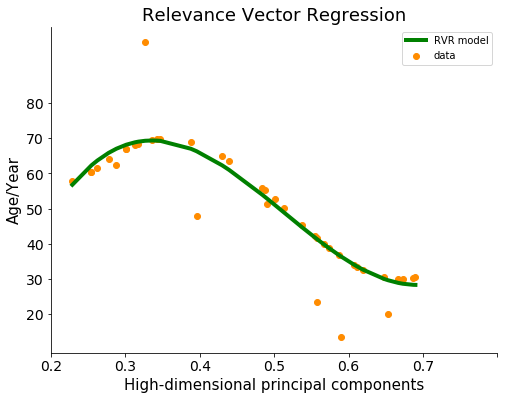

In [57]:
X = np.sort(np.random.rand(40, 1), axis=0)
y = np.sin(X*5).ravel()/1

# #############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e4, gamma=0.2)
y_rbf = svr_rbf.fit(X, y).predict(X)
# #############################################################################
# Look at the results
lw = 2
plt.figure(figsize=(8,6))
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, y_rbf, color='green', lw=4, label='RVR model')
plt.xlabel('High-dimensional principal components',size=15)
plt.ylabel('Age/Year',size=15)
plt.yticks([-1.5,-1,-0.5,0,0.5,1.0,1.5],[20,30,40,50,60,70,80],size=14)
plt.xticks([0,0.2,0.4,0.6,0.8,1,1.2],[0.2,0.3,0.4,0.5,0.6,0.7],size=14)
plt.title('Relevance Vector Regression',size=18)
ax=plt.gca()
ax.spines['top'].set_color('none')
ax.spines["right"].set_color('none')
plt.legend(loc='best')
filep='C:/Users/Shi Wen/Desktop/11.jpg'
plt.savefig(filep,dpi=500)


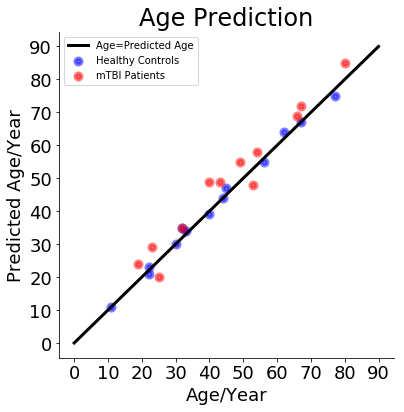

In [96]:
plt.figure(figsize=(6,6))
X1=np.array([11,22,33,44,56,67,45,32,77,22,30,62,40])
y1=np.array([11,23,34,44,55,67,47,35,75,21,30,64,39])
X2=np.array([19,25,66,53,23,54,43,49,32,80,67,40])
y2=np.array([24,20,69,48,29,58,49,55,35,85,72,49])
plt.scatter(X1, y1, color='blue', label='Healthy Controls',linewidths=4,alpha=0.5)
plt.scatter(X2, y2, color='red', label='mTBI Patients',linewidths=4,alpha=0.5)
plt.xlabel('Age/Year',size=18)
plt.ylabel('Predicted Age/Year',size=18)
plt.plot([0,90],[0,90],color='black',label='Age=Predicted Age',linewidth=3)
plt.yticks([0,10,20,30,40,50,60,70,80,90],[0,10,20,30,40,50,60,70,80,90],size=18)
plt.xticks([0,10,20,30,40,50,60,70,80,90],[0,10,20,30,40,50,60,70,80,90],size=18)
plt.title('Age Prediction',size=24)
ax=plt.gca()
ax.spines['top'].set_color('none')
ax.spines["right"].set_color('none')
plt.legend(loc='best')
filep='C:/Users/Shi Wen/Desktop/12.jpg'
plt.savefig(filep,dpi=500)

In [82]:
print(help(plt.scatter))

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, hold=None, data=None, **kwargs)
    Make a scatter plot of `x` vs `y`.
    
    Marker size is scaled by `s` and marker color is mapped to `c`.
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data
    
    s : scalar or array_like, shape (n, ), optional
        size in points^2.  Default is `rcParams['lines.markersize'] ** 2`.
    
    c : color, sequence, or sequence of color, optional, default: 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs
        (see below). Note that `c` should not be a single numeric RGB or
        RGBA sequence because that is indistinguishable from an arra